In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
# from skcuda.linalg import PCA as cuPCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from ta.volatility import AverageTrueRange, BollingerBands
from ta.trend import EMAIndicator
from ta.momentum import UltimateOscillator, StochasticOscillator, ROCIndicator, RSIIndicator, WilliamsRIndicator
from statsmodels.tsa.arima_model import ARIMA

%matplotlib inline
WS = 20

In [2]:
df = pd.read_csv('F:\\ut\\8\\proje\\data\\newbit.csv').dropna()
df = df.iloc[[x for x in range(0,20000,10)]]

In [3]:
class Bitcoin(nn.Module):
    def __init__(self,inSize, hiddenSize, outSize, ws):
        super().__init__()
        self.hiddenSize = hiddenSize
        self.inSize = inSize
        self.ws = ws
        lstm = []
        for i,item in enumerate(hiddenSize):
            lstm.append(nn.LSTM(inSize,hiddenSize[i],num_layers=2,dropout=.2))
            inSize = hiddenSize[i]
        self.lstm = nn.ModuleList(lstm)
        self.linear = nn.Linear(hiddenSize[-1], outSize)
        self.reset()
    def reset(self):
        self.hiddenMemory =[]
        for item in self.hiddenSize:
            self.hiddenMemory.append((torch.zeros(2,1,item).cuda(),\
                            torch.zeros(2,1,item).cuda()))
    def forward(self,seq):
        seq=seq.view(self.ws, -1, self.inSize)
        for i,item1 in enumerate(self.hiddenMemory):
            seq ,self.hiddenMemory[i]= self.lstm[i](seq, self.hiddenMemory[i])
        x = self.linear(seq)
        return x[-1]

In [4]:
#%%
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 10, 3, 1)
        self.conv2 = nn.Conv2d(10, 20, 3, 1)
        self.conv3 = nn.Conv2d(20, 40, 4, 1)

        self.fc1 = nn.Linear(13*25*40, 200)
        self.fc2 = nn.Linear(200, 110)
        self.fc3 = nn.Linear(110,50)
        self.fc4 = nn.Linear(50,1)
        
        self.drop1 = nn.Dropout(p=.3)
        self.drop2 = nn.Dropout(p=.3)

    def forward(self, X):
        X = self.conv1(X)
        X = self.conv2(X)
        X = self.conv3(X)
        X = X.view(-1, 13*25*40)
        X = self.fc1(X)
        X = self.drop1(X)
        X = self.fc2(X)
        X = self.drop2(X)
        X = self.fc3(X)
        X = self.fc4(X)
        return X

In [5]:
def make_input(seq,ws, st_col, end_col):
    output = []
    for item in range(len(seq) - ws):
        output.append(((torch.FloatTensor(pd.DataFrame([x[st_col:end_col] for x in seq[item:item+ws]])\
                                    .values.astype(float).reshape(1,1,20,32)).cuda()),\
                        torch.FloatTensor(np.array(seq[item + ws:item + ws+1][-1][-1])).cuda()))
    return output


In [6]:
#%%
def PCA_function(data_frame, n_components):
    sc = StandardScaler()
    X_train = sc.fit_transform(data_frame)
    pca = PCA(n_components=n_components)
    X_train = pca.fit_transform(X_train)
    return X_train



In [7]:
#%%
def arima_model(data):
    return ARIMA(data, order=(1,1,1)).fit().forecast(steps=1)[0]



In [8]:
#%% 
def add_indicators():
    added_columns = ['MA5','MA10','MA20', 'DIFF', 'BU', 'BL', 'Stochastic', \
                 'ROC', 'RSI6', 'RSI12', 'ATR', 'WR5', 'WR10', 'UOS'\
                     'I30', 'I31', 'I32', 'I33', 'I34', 'I35', 'I36', \
                      'I28', 'I29'   ]
    close = df['Close']
    df['MA5'] = close.rolling(window=5).mean()
    df['MA10'] = close.rolling(window=10).mean()
    df['MA20'] = close.rolling(window=20).mean()
    df['DIFF'] = EMAIndicator(close, n=12).ema_indicator() - EMAIndicator(close, n=26).ema_indicator()
    df['BL']=BollingerBands(close, n=20, ndev=2).bollinger_lband()
    df['BU']=BollingerBands(close, n=20, ndev=2).bollinger_hband()
    df['Stochastic']=StochasticOscillator(df['High'], df['Low'], close).stoch()
    df['ROC'] = ROCIndicator(close).roc()
    df['RSI6'] = RSIIndicator(close, 6).rsi()
    df['RSI12'] = RSIIndicator(close, 12).rsi()
    df['ATR'] = AverageTrueRange(df['High'],df['Low'], close).average_true_range() 
    df['WR10'] = WilliamsRIndicator(df['High'],df['Low'], close, lbp=10).wr()
    df['WR5'] = WilliamsRIndicator(df['High'],df['Low'], close, lbp=5).wr()
    df['UOS'] = UltimateOscillator(df['High'],df['Low'], close,).uo()
    df['I28'] = close.diff(1) / close.shift(1)
    df['I29'] = (close - df['Open']) / df['Open']
    df['I30'] = (close - df['High']) / (df['High'] - df['Low'])
    df['I31'] = df['MA5'].diff(1) / df['MA5'].shift(1)
    df['I32'] = df['MA10'].diff(1) / df['MA10'].shift(1)
    df['I33'] = df['MA20'].diff(1) / df['MA20'].shift(1)
    df['I34'] = df['MA5'].diff(1) / df['MA20'].shift(1)
    df['I35'] = (close - np.array([np.amin(close[:x]) for x in range(len(close))]))/np.array([np.amin(close[:x]) for x in range(len(close))])
    df['I36'] = (close - np.array([np.amax(close[:x]) for x in range(len(close))]))/np.array([np.amax(close[:x]) for x in range(len(close))])
    df.dropna(inplace= True)
    return added_columns

In [9]:
instance = ConvolutionalNetwork().cuda()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(instance.parameters(), lr = .001)
torch.manual_seed(403)

In [10]:
scaler = MinMaxScaler(feature_range=(0, 1 ))
add_indicators()
new_df = df
# new_df = np.array(PCA_function(df, 20))
new_df=np.append(new_df, df['Close'].values.astype(float).reshape(-1,1), axis=1)
new_df = pd.DataFrame(data=new_df)

train_set = np.array(new_df[-500:-100].values.astype(float))
train_set = scaler.fit_transform(train_set)
train_set = make_input(train_set, WS, st_col=0, end_col=32)

test = new_df[-100:].values.astype(float)
test = scaler.fit_transform(test)
test = make_input(test,WS, st_col=0, end_col=32)

In [15]:
train_set[1][0]

tensor([[[[2.3680e-03, 2.3680e-03, 8.4194e-01, 8.1385e-01, 8.7040e-01,
           8.2523e-01, 1.0307e-04, 1.0306e-04, 8.3784e-01, 9.3749e-01,
           9.6430e-01, 9.9889e-01, 6.0725e-01, 9.9803e-01, 7.7398e-01,
           2.1414e-01, 5.2637e-01, 4.0974e-01, 4.5736e-01, 2.0369e-01,
           3.1921e-01, 1.3075e-01, 3.5106e-01, 7.5945e-01, 3.1936e-01,
           1.0000e+00, 7.7297e-01, 5.9701e-01, 5.4601e-01, 7.6598e-01,
           8.2523e-01, 8.2523e-01],
          [4.7360e-03, 4.7360e-03, 8.5287e-01, 8.3066e-01, 8.8116e-01,
           8.4158e-01, 1.8680e-03, 1.8686e-03, 8.5447e-01, 9.3456e-01,
           9.6017e-01, 1.0000e+00, 6.0656e-01, 1.0000e+00, 7.7375e-01,
           3.2584e-01, 5.4246e-01, 4.9863e-01, 4.9921e-01, 1.8313e-01,
           4.8570e-01, 4.5975e-01, 4.1328e-01, 7.7214e-01, 3.3914e-01,
           1.0000e+00, 7.4627e-01, 6.3334e-01, 5.4993e-01, 7.3884e-01,
           8.4158e-01, 8.4158e-01],
          [7.1040e-03, 7.1040e-03, 8.3966e-01, 8.2989e-01, 8.6552e-01,
     

In [16]:
conv1 = nn.Conv2d(1, 26, 3, 1).cuda()
conv2 = nn.Conv2d(6, 16, 3, 1).cuda()

In [17]:
conv1(train_set[1][0]).shape

torch.Size([1, 26, 18, 30])

In [35]:
X = F.relu(conv1(train_set[1][0]))
# X = F.max_pool2d(X, 2, 2)
X = F.relu(conv2(X))
# X = F.max_pool2d(X, 2, 2)

In [36]:
X.shape

torch.Size([1, 16, 16, 28])

C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:431: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


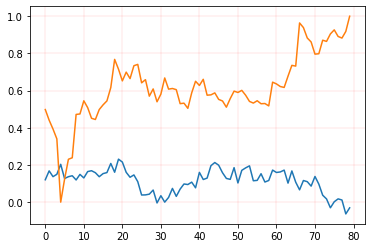

0 tensor(0.0009, device='cuda:0', grad_fn=<MseLossBackward>)


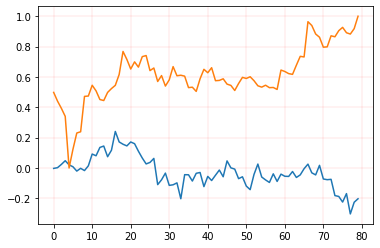

1 tensor(0.0018, device='cuda:0', grad_fn=<MseLossBackward>)


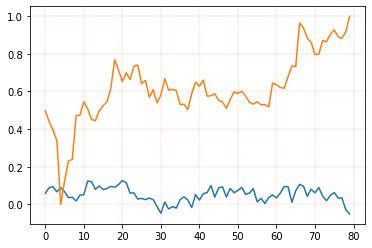

2 tensor(0.0116, device='cuda:0', grad_fn=<MseLossBackward>)


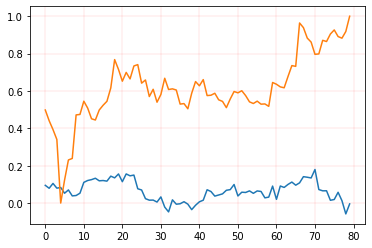

3 tensor(0.0100, device='cuda:0', grad_fn=<MseLossBackward>)


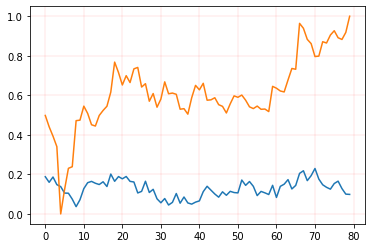

4 tensor(0.0040, device='cuda:0', grad_fn=<MseLossBackward>)


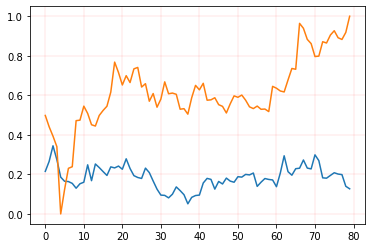

5 tensor(0.0036, device='cuda:0', grad_fn=<MseLossBackward>)


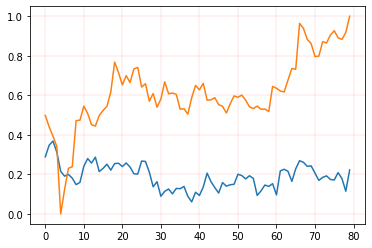

6 tensor(0.0028, device='cuda:0', grad_fn=<MseLossBackward>)


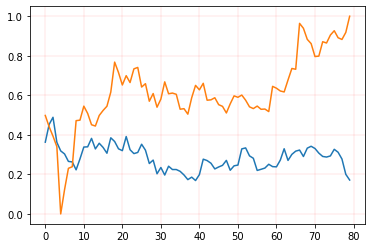

7 tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward>)


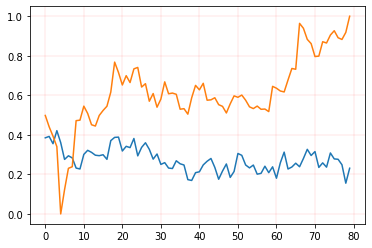

8 tensor(0.0015, device='cuda:0', grad_fn=<MseLossBackward>)


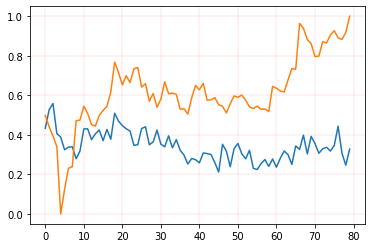

9 tensor(0.0036, device='cuda:0', grad_fn=<MseLossBackward>)


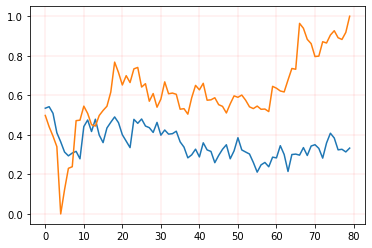

10 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)


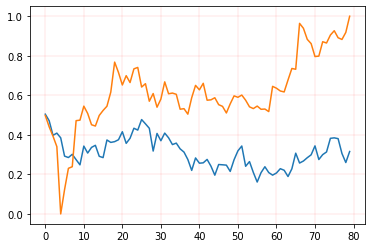

11 tensor(0.0016, device='cuda:0', grad_fn=<MseLossBackward>)


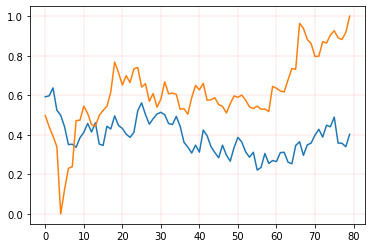

12 tensor(0.0028, device='cuda:0', grad_fn=<MseLossBackward>)


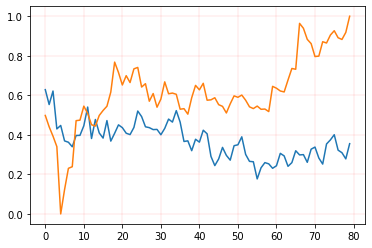

13 tensor(0.0007, device='cuda:0', grad_fn=<MseLossBackward>)


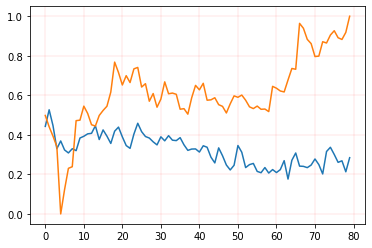

14 tensor(0.0018, device='cuda:0', grad_fn=<MseLossBackward>)


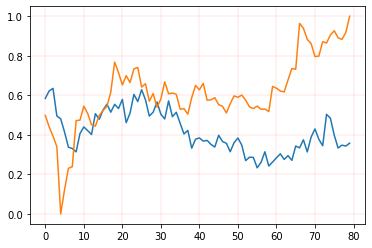

15 tensor(0.0019, device='cuda:0', grad_fn=<MseLossBackward>)


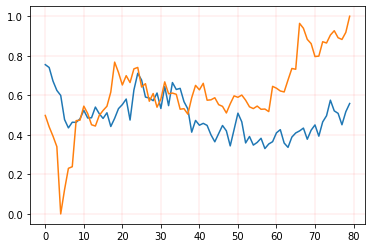

16 tensor(0.0007, device='cuda:0', grad_fn=<MseLossBackward>)


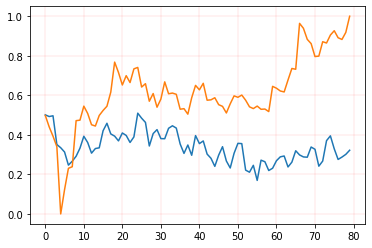

17 tensor(0.0010, device='cuda:0', grad_fn=<MseLossBackward>)


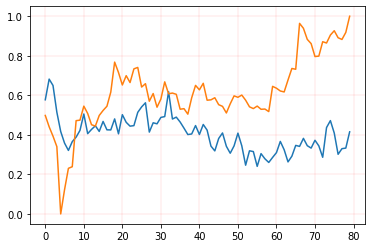

18 tensor(0.0004, device='cuda:0', grad_fn=<MseLossBackward>)


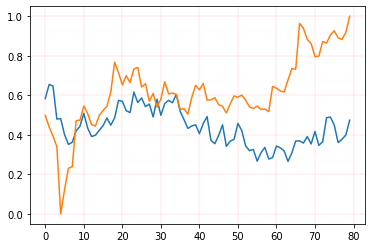

19 tensor(0.0011, device='cuda:0', grad_fn=<MseLossBackward>)


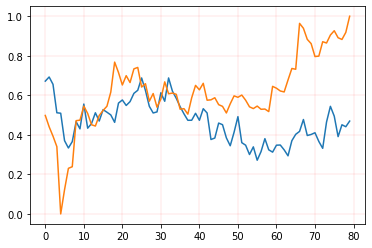

20 tensor(0.0004, device='cuda:0', grad_fn=<MseLossBackward>)


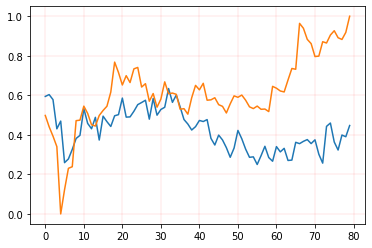

21 tensor(0.0021, device='cuda:0', grad_fn=<MseLossBackward>)


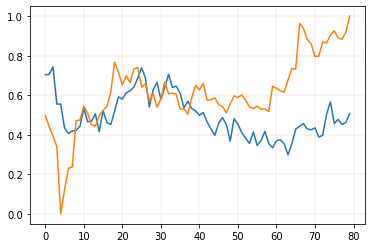

22 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)


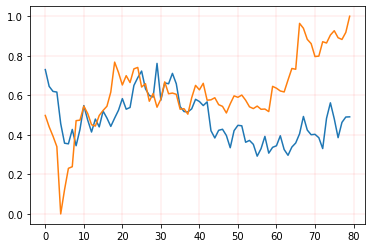

23 tensor(9.0027e-06, device='cuda:0', grad_fn=<MseLossBackward>)


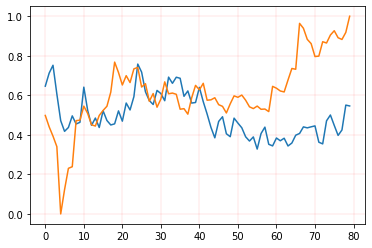

24 tensor(0.0019, device='cuda:0', grad_fn=<MseLossBackward>)


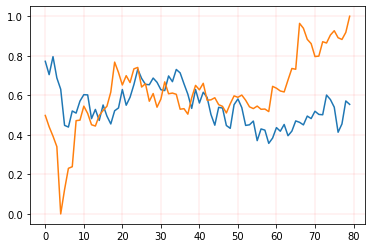

25 tensor(0.0049, device='cuda:0', grad_fn=<MseLossBackward>)


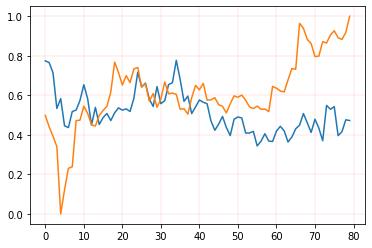

26 tensor(0.0071, device='cuda:0', grad_fn=<MseLossBackward>)


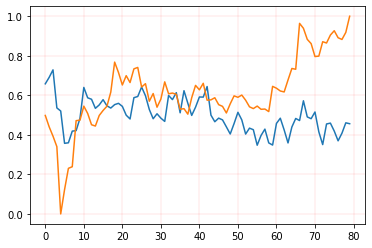

27 tensor(0.0035, device='cuda:0', grad_fn=<MseLossBackward>)


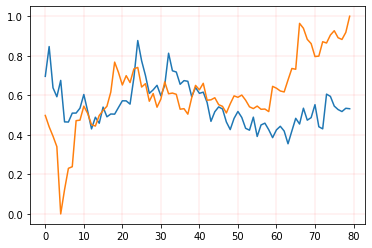

28 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)


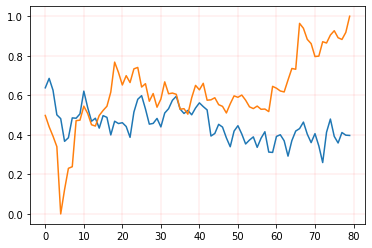

29 tensor(0.0057, device='cuda:0', grad_fn=<MseLossBackward>)


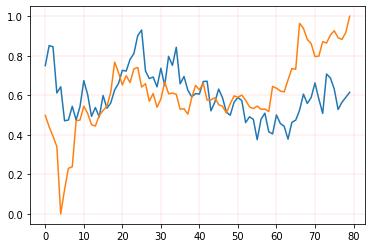

30 tensor(0.0027, device='cuda:0', grad_fn=<MseLossBackward>)


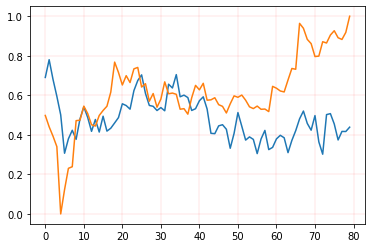

31 tensor(0.0052, device='cuda:0', grad_fn=<MseLossBackward>)


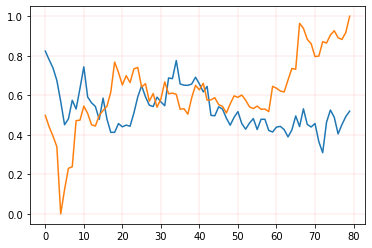

32 tensor(0.0027, device='cuda:0', grad_fn=<MseLossBackward>)


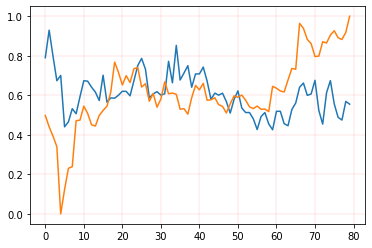

33 tensor(0.0095, device='cuda:0', grad_fn=<MseLossBackward>)


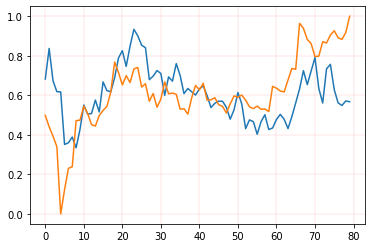

34 tensor(0.0034, device='cuda:0', grad_fn=<MseLossBackward>)


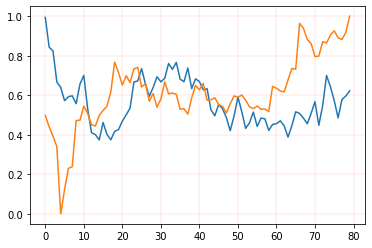

35 tensor(7.8554e-07, device='cuda:0', grad_fn=<MseLossBackward>)


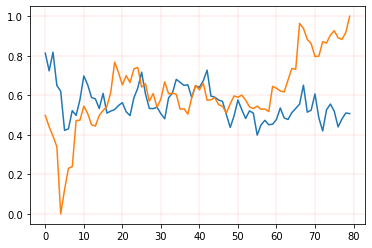

36 tensor(0.0135, device='cuda:0', grad_fn=<MseLossBackward>)


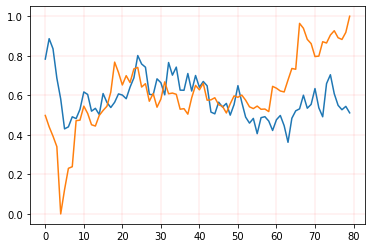

37 tensor(3.4243e-05, device='cuda:0', grad_fn=<MseLossBackward>)


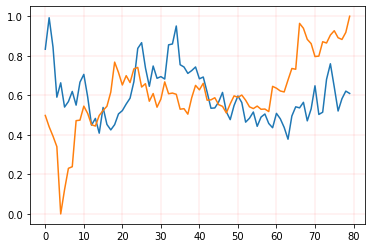

38 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)


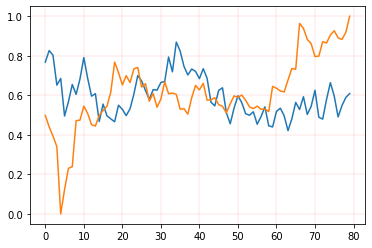

39 tensor(0.0090, device='cuda:0', grad_fn=<MseLossBackward>)


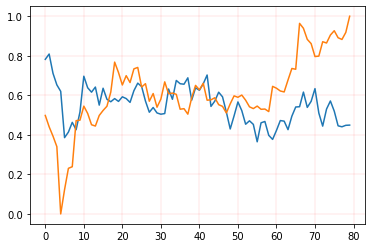

40 tensor(0.0025, device='cuda:0', grad_fn=<MseLossBackward>)


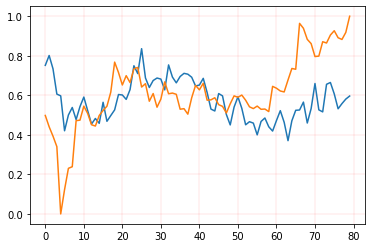

41 tensor(0.0009, device='cuda:0', grad_fn=<MseLossBackward>)


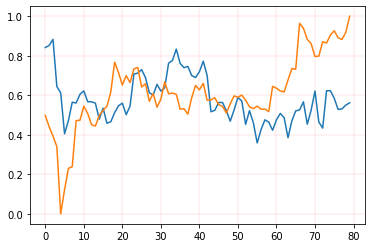

42 tensor(0.0024, device='cuda:0', grad_fn=<MseLossBackward>)


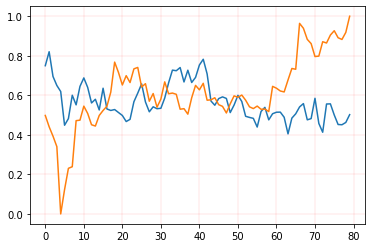

43 tensor(0.0035, device='cuda:0', grad_fn=<MseLossBackward>)


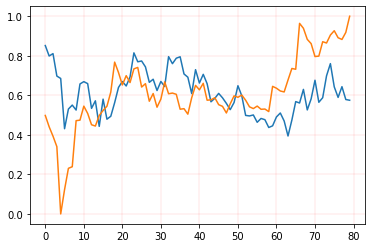

44 tensor(2.0405e-05, device='cuda:0', grad_fn=<MseLossBackward>)


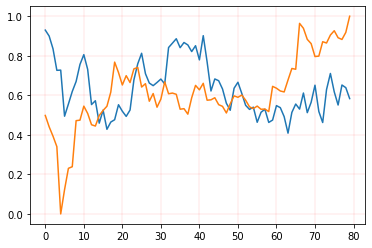

45 tensor(0.0005, device='cuda:0', grad_fn=<MseLossBackward>)


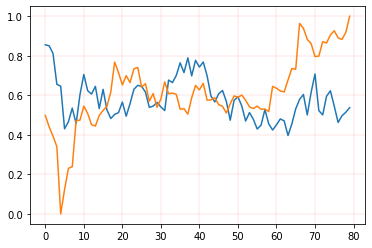

46 tensor(0.0018, device='cuda:0', grad_fn=<MseLossBackward>)


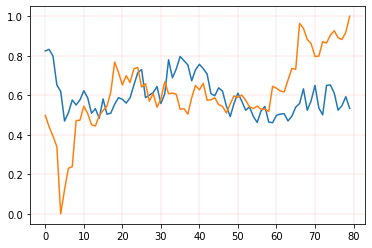

47 tensor(0.0162, device='cuda:0', grad_fn=<MseLossBackward>)


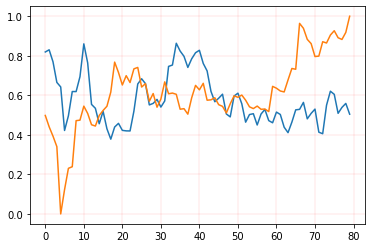

48 tensor(0.0004, device='cuda:0', grad_fn=<MseLossBackward>)


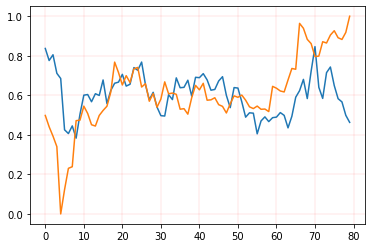

49 tensor(0.0010, device='cuda:0', grad_fn=<MseLossBackward>)


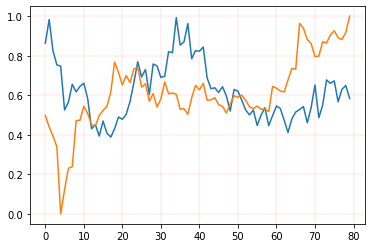

50 tensor(0.0057, device='cuda:0', grad_fn=<MseLossBackward>)


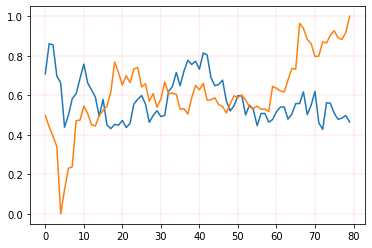

51 tensor(0.0025, device='cuda:0', grad_fn=<MseLossBackward>)


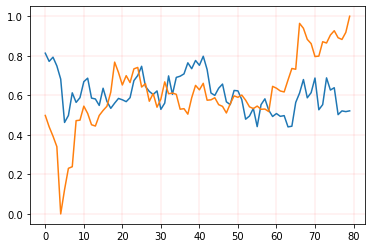

52 tensor(0.0041, device='cuda:0', grad_fn=<MseLossBackward>)


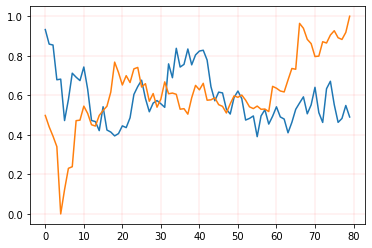

53 tensor(0.0168, device='cuda:0', grad_fn=<MseLossBackward>)


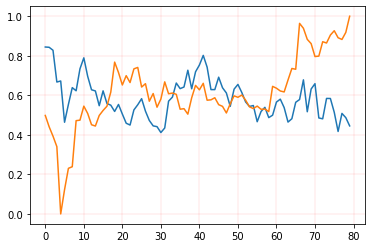

54 tensor(0.0105, device='cuda:0', grad_fn=<MseLossBackward>)


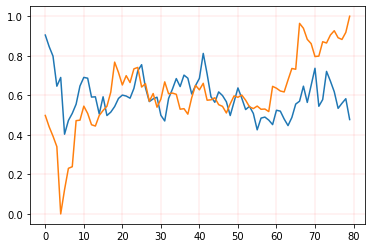

55 tensor(0.0008, device='cuda:0', grad_fn=<MseLossBackward>)


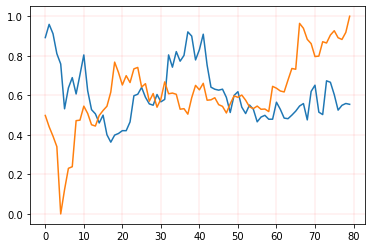

56 tensor(0.0011, device='cuda:0', grad_fn=<MseLossBackward>)


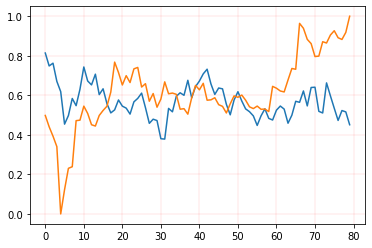

57 tensor(0.0084, device='cuda:0', grad_fn=<MseLossBackward>)


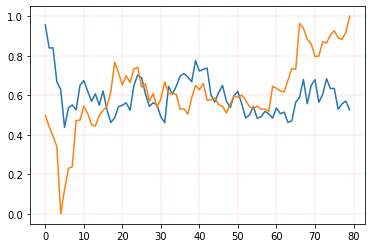

58 tensor(0.0027, device='cuda:0', grad_fn=<MseLossBackward>)


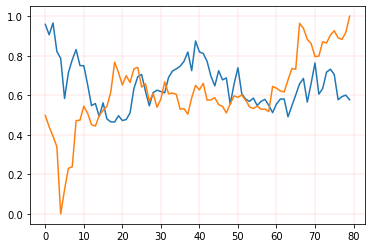

59 tensor(0.0105, device='cuda:0', grad_fn=<MseLossBackward>)


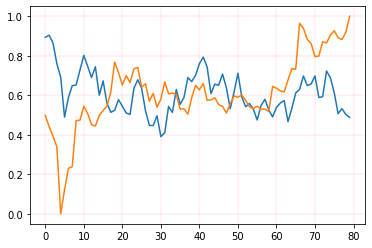

60 tensor(0.0238, device='cuda:0', grad_fn=<MseLossBackward>)


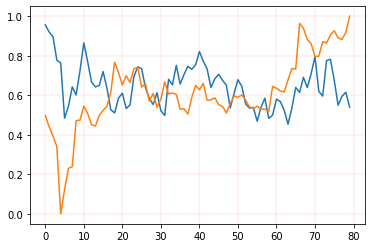

61 tensor(0.0045, device='cuda:0', grad_fn=<MseLossBackward>)


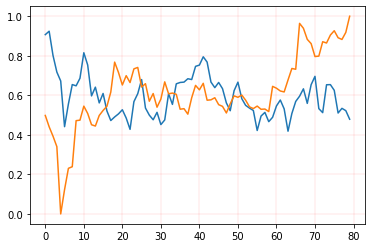

62 tensor(7.3719e-05, device='cuda:0', grad_fn=<MseLossBackward>)


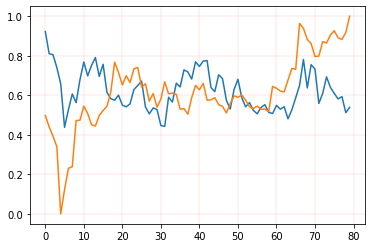

63 tensor(0.0126, device='cuda:0', grad_fn=<MseLossBackward>)


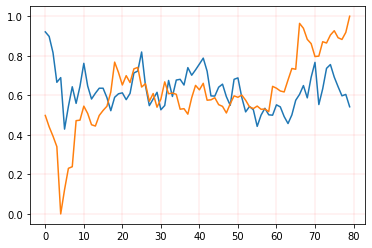

64 tensor(0.0209, device='cuda:0', grad_fn=<MseLossBackward>)


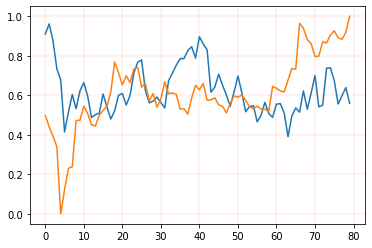

65 tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward>)


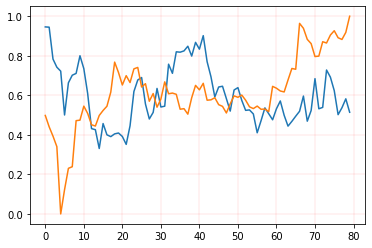

66 tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward>)


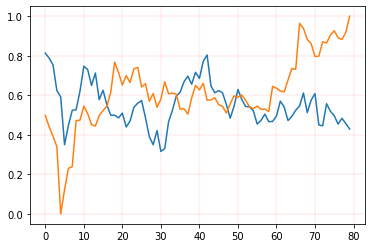

67 tensor(0.0076, device='cuda:0', grad_fn=<MseLossBackward>)


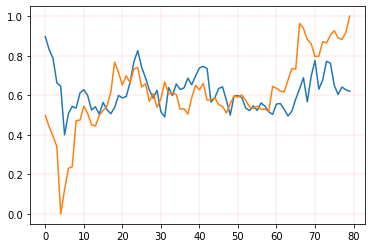

68 tensor(0.0119, device='cuda:0', grad_fn=<MseLossBackward>)


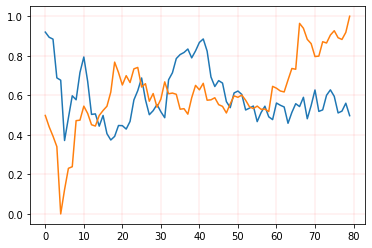

69 tensor(0.0132, device='cuda:0', grad_fn=<MseLossBackward>)


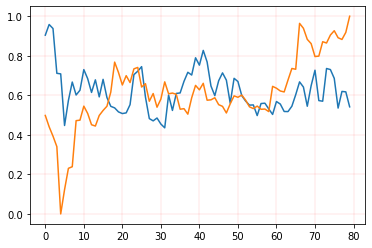

70 tensor(0.0131, device='cuda:0', grad_fn=<MseLossBackward>)


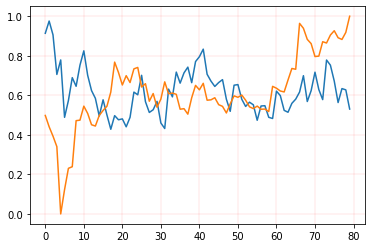

71 tensor(2.7769e-06, device='cuda:0', grad_fn=<MseLossBackward>)


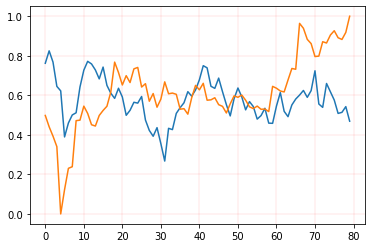

72 tensor(0.0018, device='cuda:0', grad_fn=<MseLossBackward>)


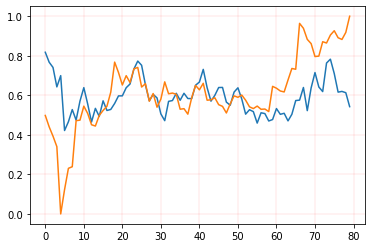

73 tensor(0.0074, device='cuda:0', grad_fn=<MseLossBackward>)


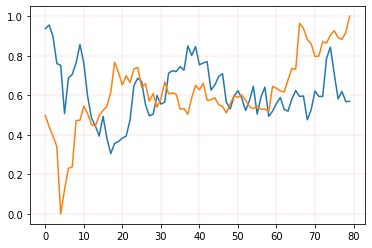

74 tensor(0.0031, device='cuda:0', grad_fn=<MseLossBackward>)


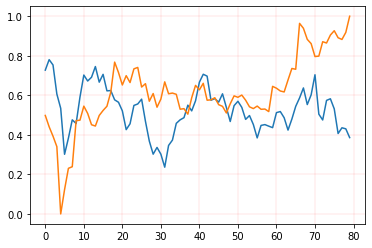

75 tensor(0.0010, device='cuda:0', grad_fn=<MseLossBackward>)


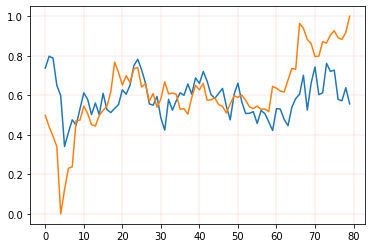

76 tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward>)


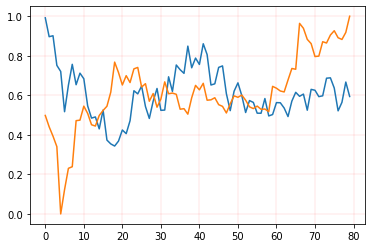

77 tensor(0.0101, device='cuda:0', grad_fn=<MseLossBackward>)


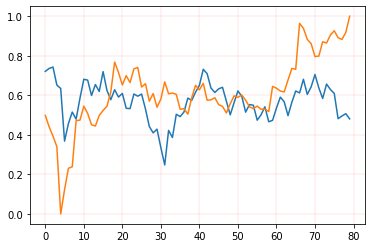

78 tensor(0.0066, device='cuda:0', grad_fn=<MseLossBackward>)


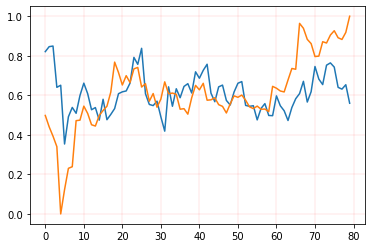

79 tensor(0.0131, device='cuda:0', grad_fn=<MseLossBackward>)


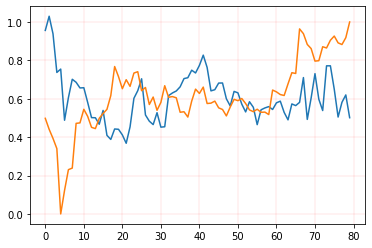

80 tensor(0.0011, device='cuda:0', grad_fn=<MseLossBackward>)


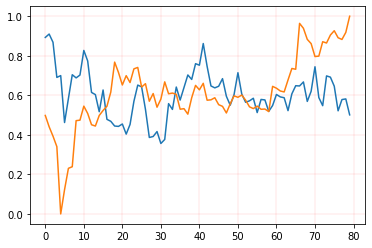

81 tensor(0.0198, device='cuda:0', grad_fn=<MseLossBackward>)


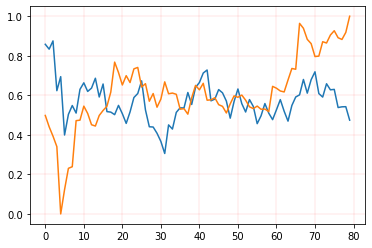

82 tensor(0.0071, device='cuda:0', grad_fn=<MseLossBackward>)


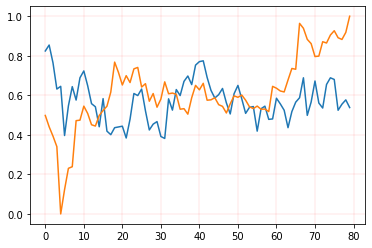

83 tensor(0.0092, device='cuda:0', grad_fn=<MseLossBackward>)


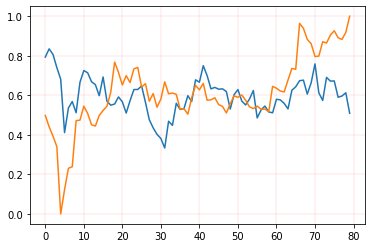

84 tensor(0.0023, device='cuda:0', grad_fn=<MseLossBackward>)


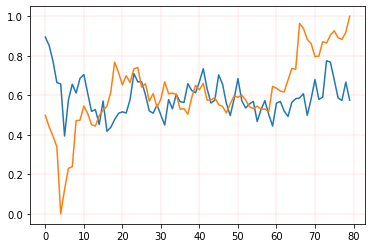

85 tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward>)


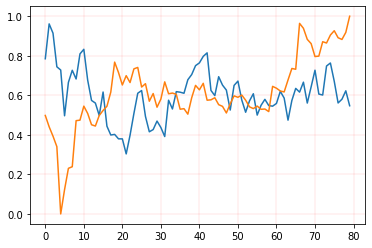

86 tensor(0.0031, device='cuda:0', grad_fn=<MseLossBackward>)


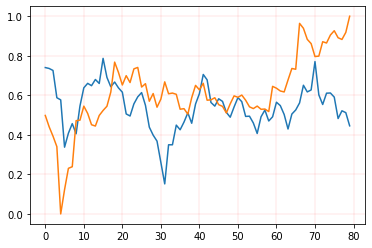

87 tensor(0.0024, device='cuda:0', grad_fn=<MseLossBackward>)


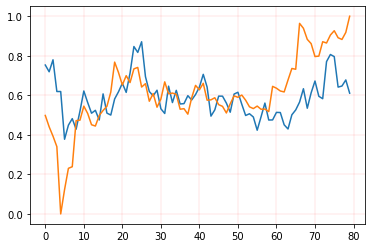

88 tensor(0.0082, device='cuda:0', grad_fn=<MseLossBackward>)


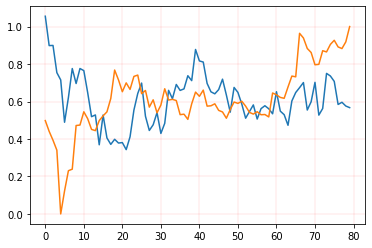

89 tensor(0.0072, device='cuda:0', grad_fn=<MseLossBackward>)


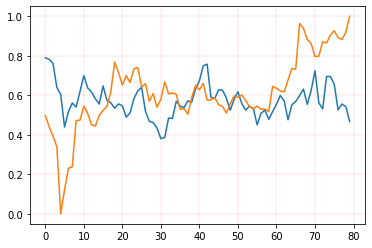

90 tensor(0.0035, device='cuda:0', grad_fn=<MseLossBackward>)


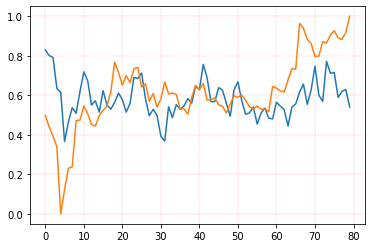

91 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)


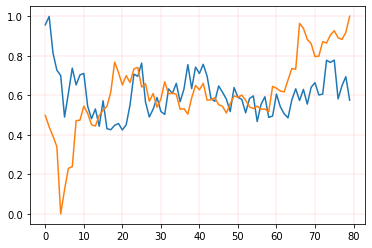

92 tensor(0.0023, device='cuda:0', grad_fn=<MseLossBackward>)


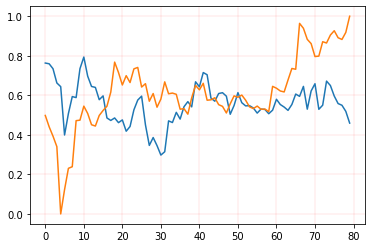

93 tensor(0.0178, device='cuda:0', grad_fn=<MseLossBackward>)


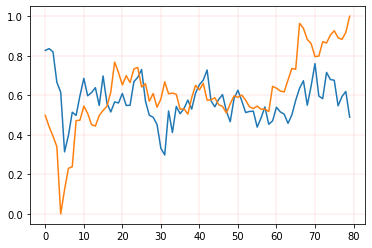

94 tensor(0.0005, device='cuda:0', grad_fn=<MseLossBackward>)


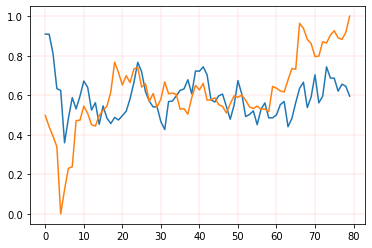

95 tensor(0.0019, device='cuda:0', grad_fn=<MseLossBackward>)


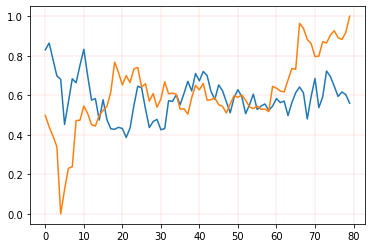

96 tensor(0.0064, device='cuda:0', grad_fn=<MseLossBackward>)


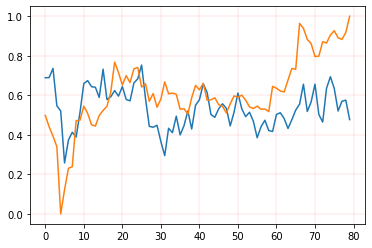

97 tensor(0.0091, device='cuda:0', grad_fn=<MseLossBackward>)


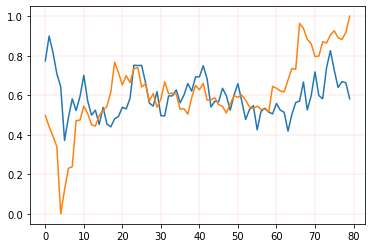

98 tensor(0.0010, device='cuda:0', grad_fn=<MseLossBackward>)


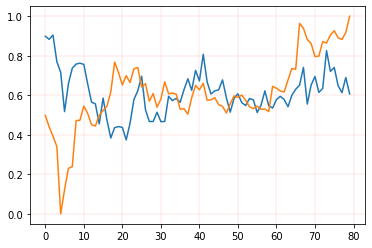

99 tensor(0.0119, device='cuda:0', grad_fn=<MseLossBackward>)


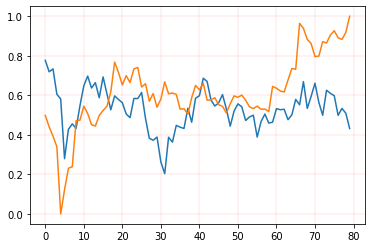

100 tensor(0.0008, device='cuda:0', grad_fn=<MseLossBackward>)


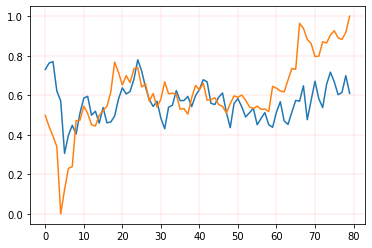

101 tensor(0.0037, device='cuda:0', grad_fn=<MseLossBackward>)


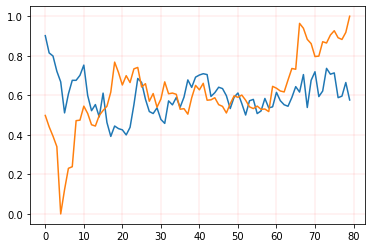

102 tensor(0.0010, device='cuda:0', grad_fn=<MseLossBackward>)


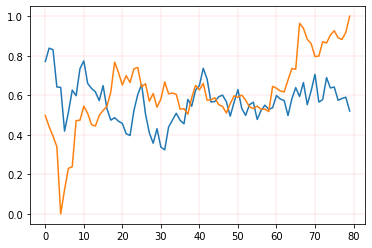

103 tensor(0.0227, device='cuda:0', grad_fn=<MseLossBackward>)


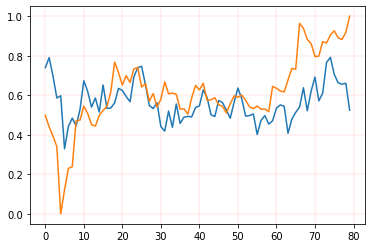

104 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)


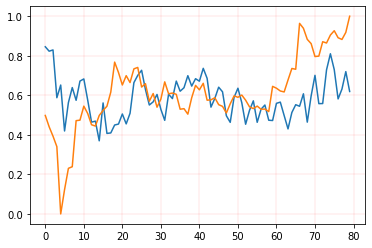

105 tensor(0.0026, device='cuda:0', grad_fn=<MseLossBackward>)


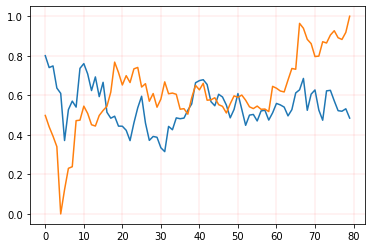

106 tensor(0.0027, device='cuda:0', grad_fn=<MseLossBackward>)


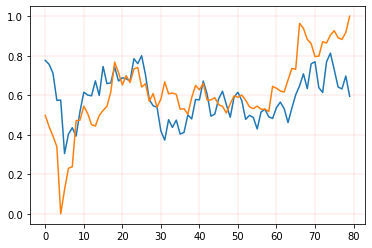

107 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)


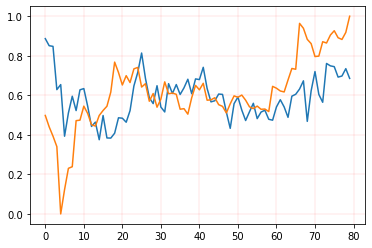

108 tensor(1.4361e-05, device='cuda:0', grad_fn=<MseLossBackward>)


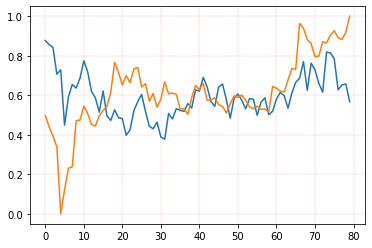

109 tensor(0.0244, device='cuda:0', grad_fn=<MseLossBackward>)


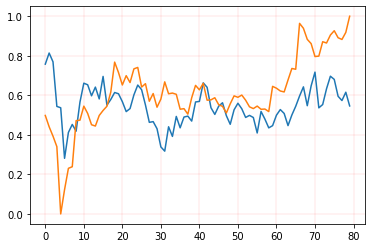

110 tensor(9.8915e-05, device='cuda:0', grad_fn=<MseLossBackward>)


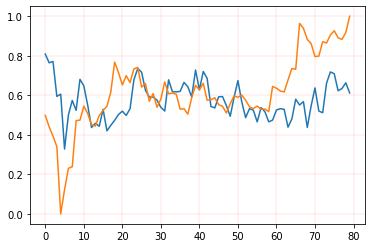

111 tensor(0.0016, device='cuda:0', grad_fn=<MseLossBackward>)


In [ ]:
# %%
epoch = 400
preds_in_learn = []
reals_in_learn = []
optimizer = torch.optim.Adam(instance.parameters(), lr=.0001)
for i in range(epoch):
    for seq, y in train_set:
        pred = instance.forward(seq)
        loss = criterion(pred,y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    with torch.no_grad():
        for item , y in test:
            preds_in_learn.append(instance.forward(item))
            reals_in_learn.append(y)
    plt.plot(range(80), preds_in_learn[-80:],)
    # plt.show()
    plt.grid(color='r', linestyle='-', linewidth=.1, zorder=.1)
    # plt.show()
    plt.plot(range(80), reals_in_learn[-80:])
    plt.show()
    preds_in_learn.clear()
    reals_in_learn.clear()
    print(i, loss)

In [21]:
torch.save(instance.state_dict(),'PCA_CNN_OUT20_32Indicators_TrainSize400.pn')

In [10]:
instance = ConvolutionalNetwork().cuda()
instance.load_state_dict(torch.load('PCA_CNN_OUT20_32Indicators.pn'))
instance = instance.cuda()